<a href="https://colab.research.google.com/github/seyeala/Piecwise-Polynomial-Models-with-Shared-Coefficients-in-Tensorflow/blob/main/duallosscurvefi_sharedCs_Mooney_Cutnocut%2B_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

In [46]:
from google.colab import drive
drive.mount('/content/drive')
foldername='otest'
filenamecut='1d-tensile.csv'
filenamenocut='plannar-shear.csv'
filenamecutpath='/content/drive/MyDrive/'+foldername+'/'+filenamecut
filenamenocutpath='/content/drive/MyDrive/'+foldername+'/'+filenamenocut
numberofbrakpoints=1


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
loading_or_unloading=1
epch=10000

In [48]:
datacut = pd.read_csv(
    filenamecutpath,
    names=["A", "B"])

datacut.head()

,A,B
0,241.724,-0.6052
1,241.831,-0.5304
2,242.616,-0.4420
3,244.429,-0.3876
4,242.732,-0.2924


In [49]:
datanocut = pd.read_csv(
    filenamenocutpath,
    names=["A", "B"])

datanocut.head()

,A,B
0,241.587,-0.4964
1,240.750,-0.4080
2,241.781,-0.3536
3,243.890,-0.3128
4,243.612,-0.1972


In [50]:
all_datacut = datacut.copy()

inputscut = all_datacut.pop('A')
labelscut = all_datacut.pop('B')



In [51]:
all_datanocut = datanocut.copy()

inputsnocut = all_datanocut.pop('A')
labelsnocut = all_datanocut.pop('B')


In [52]:
factor=1000000
area= 3e-6
x_datacut=inputscut.to_numpy(dtype=np.float32)
y_datacut=labelscut.to_numpy(dtype=np.float32)/factor

y_datacut=y_datacut-y_datacut[0]

x_datanocut=inputsnocut.to_numpy(dtype=np.float32)
y_datanocut=labelsnocut.to_numpy(dtype=np.float32)/factor

y_datanocut=y_datanocut-y_datanocut[0]

y_datacut = (y_datacut)/area

# For y_datanocut
y_datanocut = (y_datanocut )/area


In [53]:
y_datacut

array([ 0.        ,  0.02493334,  0.0544    ,  0.07253333,  0.10426666,
        0.12693333,  0.1564    ,  0.1768    ,  0.21533333,  0.2312    ,
        0.26973333,  0.28786666,  0.3196    ,  0.34226667,  0.37853332,
        0.39666667,  0.43293333,  0.44879999,  0.48506667,  0.50093333,
        0.53493333,  0.5576    ,  0.5916    ,  0.60973332,  0.64600001,
        0.66186665,  0.68906667,  0.70946668,  0.74346668,  0.7616    ,
        0.79786668,  0.816     ,  0.84773332,  0.86586668,  0.89986664,
        0.91573332,  0.94973332,  0.96786664,  1.00186664,  1.01773332,
        1.05173331,  1.06759999,  1.09933335,  1.12199996,  1.14920002,
        1.1650667 ,  1.1990667 ,  1.2149333 ,  1.2489333 ,  1.2670667 ,
        1.29653333,  1.3124    ,  1.34413336,  1.36000003,  1.38946666,
        1.39400003,  1.35320002,  1.33733334,  1.3010667 ,  1.28066665,
        1.2444    ,  1.22400004,  1.18999996,  1.17186664,  1.13786664,
        1.11520002,  1.08120002,  1.06079998,  1.02679998,  1.00

In [54]:
from tensorflow.keras.constraints import MinMaxNorm


In [55]:



# 1. Define the Shared Coefficient c
class SharedCoefficientLayer(tf.keras.layers.Layer):
    def __init__(self, size, initial_value=None, **kwargs):
        super(SharedCoefficientLayer, self).__init__(**kwargs)
        self.size = size
        self.initial_value = initial_value

    def build(self, input_shape):
        if self.initial_value is not None:
            initializer = tf.keras.initializers.Constant(self.initial_value)
        else:
            initializer = 'uniform'

        self.c = self.add_weight(name='c',
                                 shape=(self.size,),
                                 initializer=initializer,
                                 trainable=True)
        super(SharedCoefficientLayer, self).build(input_shape)

    def call(self, inputs):
        return self.c






# 3. Construct the Model with Shared Coefficients
import tensorflow as tf



def get_dimensions(matrix):
    rows = len(matrix)
    cols = len(matrix[0]) if rows > 0 else 0
    return (rows, cols)
# Modify the build_dual_polynomial_model function

# Add this function to your code
def high_temperature_sigmoid(x, k=1):
    return 1.0 / (1.0 + tf.exp(-k * x))

# Modify the DualPolynomialLayer to accept external coefficients
# Add this function to your code

# Modify the DualPolynomialLayer to accept external coefficients
class DualPolynomialLayerModified(tf.keras.layers.Layer):
    def __init__(self, power, h, **kwargs):
        super(DualPolynomialLayerModified, self).__init__(**kwargs)
        self.power = power
        self.h = tf.constant(h, dtype=tf.float32)  # Convert to a constant tensor

    def build(self, input_shape):
        self.breakx = self.add_weight(name='breakx',
                                      shape=(1,),
                                      initializer=tf.constant_initializer(value=250),
                                      constraint=MinMaxNorm(min_value=50, max_value=400, rate=1.0, axis=0),
                                      trainable=True)

        self.breaky = self.add_weight(name='breaky',
                                      shape=(1,),
                                      initializer=tf.constant_initializer(value=0),
                                      trainable=True)
        super(DualPolynomialLayerModified, self).build(input_shape)

    def call(self, inputs, **kwargs):
        x, c = inputs

        # Calculate the polynomial terms for each power

        poly_terms = [tf.math.pow(x/(self.breakx), p) for p in self.power]
        poly_tensor = tf.stack(poly_terms, axis=-1)

        # Perform matrix multiplication with h and c
        output_terms = tf.matmul(poly_tensor, self.h)

        # Now, sum along the last dimension after multiplying with c
        poly_output = tf.reduce_sum(output_terms * c, axis=-1)

        # Apply the sigmoid-based conditioning
        sigmoid_term = high_temperature_sigmoid(x - self.breakx)
        outputs = (poly_output+self.breaky) * sigmoid_term + self.breaky * (1.0 - sigmoid_term)

        return outputs


def build_dual_polynomial_model(powers, h1, h2):
    # Ensure the powers argument contains the required sublists
    if 'powers1' not in powers or 'powers2' not in powers:
        raise ValueError("The 'powers' argument must contain 'powers1' and 'powers2' sublists.")

    # Create the model's input layers
    inputs1 = tf.keras.Input(shape=(1,), name='input_1')
    inputs2 = tf.keras.Input(shape=(1,), name='input_2')

    rowh1,colh1=get_dimensions(h1)
    rowh2,colh2=get_dimensions(h2)
    if colh1!=colh2:
        raise ValueError("Share C values dont match")


    # Shared coefficients layer
    initial_c_values = [0.5, -0.5]
    shared_c_layer = SharedCoefficientLayer(size=colh1, initial_value=initial_c_values, name="shared_coefficients_layer")
    shared_c = shared_c_layer(inputs1)
    # First polynomial layer with h1 matrix
    layer1 = DualPolynomialLayerModified(power=powers['powers1'], h=h1, name="dual_polynomial_1")
    outputs1 = layer1([inputs1, shared_c])

    # Second polynomial layer with h2 matrix
    layer2 = DualPolynomialLayerModified(power=powers['powers2'], h=h2, name="dual_polynomial_2")
    outputs2 = layer2([inputs2, shared_c])

    # Build and return the model
    model = tf.keras.Model(inputs=[inputs1, inputs2], outputs={'output_1': outputs1, 'output_2': outputs2})
    return model



# 4. Design the Combined Loss Function
# Assuming mean squared error for both, adjust as needed
def combined_loss(y_true, y_pred):
    #print("Shape of y_true:", tf.shape(y_true))
    #print("Shape of y_pred:", tf.shape(y_pred))

    loss1 = tf.keras.losses.MSE(y_true[0], y_pred[0])
    loss2 = tf.keras.losses.MSE(y_true[1], y_pred[1])
    return loss1 + loss2

#powers_dict = {'powers1': [1,-1,-3,-1], 'powers2': [-1, -2,-3,0]}
#powers_dict = {'powers1': [3,1,-1,1] 2 -1, 'powers2': [1, 0,-1,2]} 2 0 -2 0
powers_dict = {'powers1': [1,-2,-3,0], 'powers2': [1, -1,-3,-1]}
h_matrix1 = [[2, 0], [-2, 0], [0, -2],[0,2]]
h_matrix2 =[[2, 0], [-2, 0], [0,-2],[0,2] ]  # or any other matrix you'd like
model = build_dual_polynomial_model(powers_dict, h_matrix1, h_matrix2)

#https://en.wikipedia.org/wiki/Mooney%E2%80%93Rivlin_solid

In [56]:
m = len(x_datanocut)
n = len(x_datacut)

x_datacut_replicated = np.tile(x_datacut, m)
y_datacut_replicated = np.tile(y_datacut, m)

x_datanocut_replicated = np.tile(x_datanocut, n)
y_datanocut_replicated = np.tile(y_datanocut, n)

# Form a and b using reshaped data
a = [x_datacut_replicated.reshape((-1, 1)), x_datanocut_replicated.reshape((-1, 1))]
b = [y_datacut_replicated.reshape((-1, 1)), y_datanocut_replicated.reshape((-1, 1))]

In [57]:
# Set a custom learning rate
# Create the Adam optimizer with the custom learning rate
optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)

# Compile the model with the custom optimizer
model.compile(optimizer=optimizer,
              loss={'output_1': 'mse', 'output_2': 'mse'},
              metrics={'output_1': 'mse', 'output_2': 'mse'})


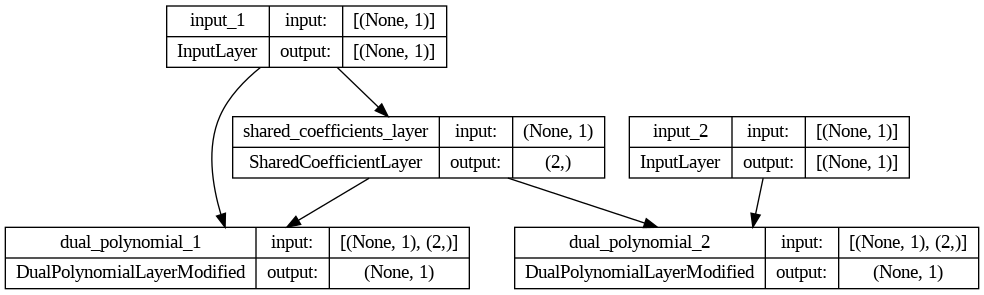

In [58]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [69]:
input_names = [input_layer.name.split(':')[0] for input_layer in model.inputs]

input_data_dict = {input_names[0]: a[0], input_names[1]: a[1]}
output_data_dict = {'output_1': b[0], 'output_2': b[1]}

history = model.fit(input_data_dict, output_data_dict, epochs=10000, batch_size=320)


Epoch 1/10000
348/348 [==============================] - 2s 6ms/step - loss: 0.0055 - dual_polynomial_1_loss: 0.0017 - dual_polynomial_2_loss: 0.0038 - dual_polynomial_1_mse: 0.0017 - dual_polynomial_2_mse: 0.0038
Epoch 2/10000
348/348 [==============================] - 3s 7ms/step - loss: 0.0055 - dual_polynomial_1_loss: 0.0017 - dual_polynomial_2_loss: 0.0038 - dual_polynomial_1_mse: 0.0017 - dual_polynomial_2_mse: 0.0038
Epoch 3/10000
348/348 [==============================] - 3s 9ms/step - loss: 0.0055 - dual_polynomial_1_loss: 0.0017 - dual_polynomial_2_loss: 0.0038 - dual_polynomial_1_mse: 0.0017 - dual_polynomial_2_mse: 0.0038
Epoch 4/10000
348/348 [==============================] - 2s 6ms/step - loss: 0.0054 - dual_polynomial_1_loss: 0.0017 - dual_polynomial_2_loss: 0.0038 - dual_polynomial_1_mse: 0.0017 - dual_polynomial_2_mse: 0.0038
Epoch 5/10000
348/348 [==============================] - 2s 6ms/step - loss: 0.0054 - dual_polynomial_1_loss: 0.0017 - dual_polynomial_2_loss: 0

KeyboardInterrupt: ignored

In [ ]:
x_datanocut.shape

11/11 [==============================] - 0s 9ms/step


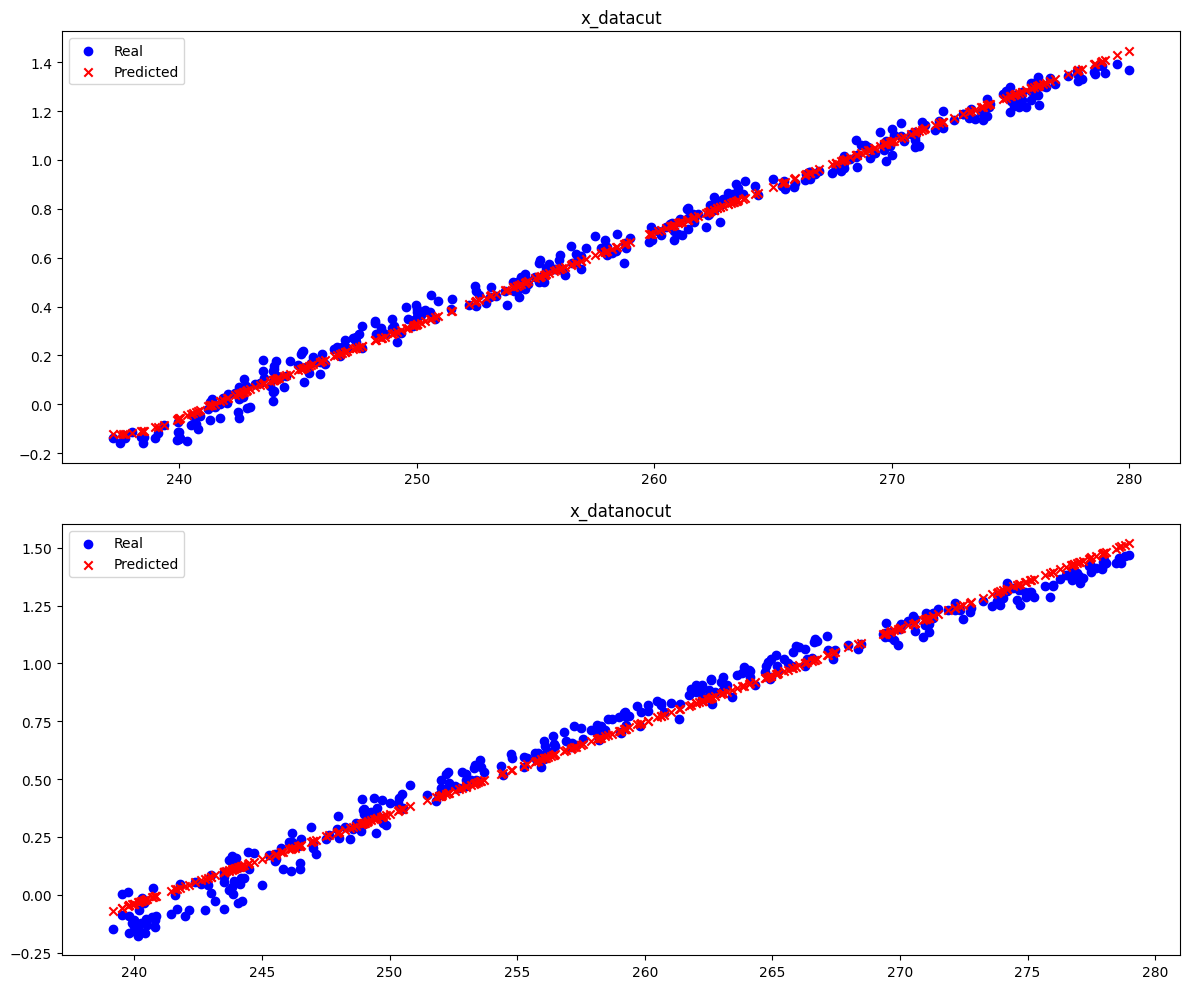

In [71]:
import matplotlib.pyplot as plt


def plot_predictions(model, x_datacut, y_datacut, x_datanocut, y_datanocut):
    # Create dummy data for each case (filled with zeros)
    dummy_data1 = np.zeros_like(x_datacut)
    dummy_data2 = np.zeros_like(x_datanocut)

    # Predict for x_datacut
    y_pred_datacut = model.predict([x_datacut, dummy_data1])['output_1']

    # Predict for x_datanocut
    y_pred_datanocut = model.predict([dummy_data2, x_datanocut])['output_2']

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))

    # Plot data for x_datacut
    ax[0].scatter(x_datacut, y_datacut, color='blue', label='Real')
    ax[0].scatter(x_datacut, y_pred_datacut, color='red', marker='x', label='Predicted')
    ax[0].set_title('x_datacut')
    ax[0].legend()

    # Plot data for x_datanocut
    ax[1].scatter(x_datanocut, y_datanocut, color='blue', label='Real')
    ax[1].scatter(x_datanocut, y_pred_datanocut, color='red', marker='x', label='Predicted')
    ax[1].set_title('x_datanocut')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Assuming x_datacut, y_datacut, x_datanocut, and y_datanocut are defined
# Call the plot function
plot_predictions(model, x_datacut, y_datacut, x_datanocut, y_datanocut)


In [70]:
shared_c_values = model.get_layer(name="shared_coefficients_layer").get_weights()[0]

# Extract breakx and breaky values for the first polynomial using its name
breakx1, breaky1 = model.get_layer(name="dual_polynomial_1").get_weights()

# Extract breakx and breaky values for the second polynomial using its name
breakx2, breaky2 = model.get_layer(name="dual_polynomial_2").get_weights()

print("Shared coefficients:", shared_c_values)

print("\nFirst Polynomial:")
print("breakx:", breakx1)
print("breaky:", breaky1)

print("\nSecond Polynomial:")
print("breakx:", breakx2)
print("breaky:", breaky2)

Shared coefficients: [ 3.1023846 -1.6147406]

First Polynomial:
breakx: [238.28152]
breaky: [-0.11244497]

Second Polynomial:
breakx: [206.707]
breaky: [-1.1795233]
